In [1]:
import numpy as np
import pandas as pd
import healpy as hp
import os
from DS_Planck_Unet import *
from DS_healpix_fragmentation import radec2pix
from matplotlib import pyplot as plt
from DS_data_transformation import draw_df
from DS_detector import *
from tqdm.notebook import tqdm

In [2]:
model = load_planck_model(
    '/home/rt2122/Models/planck_z/f8d2.ep0014-vl0.006570-l0.004067.hdf5')

In [5]:
thr_list = [0.1 * i for i in range(9, 0, -1)]

In [6]:
ep=14

In [8]:
thr=0.3
'/home/rt2122/Data/scans_extended/connected_ep{ep}_thr{thr}.csv'.format(ep=ep, thr=thr)

'/home/rt2122/Data/scans_extended/connected_ep14_thr0.3.csv'

In [ ]:
thr_dict = {thr : [] for thr in thr_list}
for i in tqdm(range(48)):
    all_dict = gen_pics_for_detection(i, model, step=16)
    for thr in thr_list:
        coords = detect_clusters_connected(all_dict, thr, i)
        thr_dict[thr].append(coords)

for thr in thr_list:
    thr_dict[thr] = pd.concat(thr_dict[thr], ignore_index=True)
    thr_dict[thr].to_csv(
        '/home/rt2122/Data/scans_extended/connected/ep{ep}_thr{thr}'.format(
            ep=ep, thr=thr), index=False)

/home/rt2122/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [12]:
df = pd.read_csv('/home/rt2122/Data/scans_extended/connected_ep14_thr0.4.csv')

In [15]:
a = {'a' : 1, 'b' : 2}
print(a)
for key in a:
    if key == 'b':
        del(a['b'])
print(a)

{'a': 1, 'b': 2}


RuntimeError: dictionary changed size during iteration

In [40]:
def recall_fp_pix(pix, files_dict,
                       figsize=(24, 6), comm_coords=(0.1, 0.6), 
                      comment=''):
    import os
    import pandas as pd
    from DS_healpix_fragmentation import radec2pix
    
    tp = {'planck_z':[], 'planck_no_z':[], 'mcxcwp' :[], 'act' : []}
    fn = {'planck_z':[], 'planck_no_z':[], 'mcxcwp' :[], 'act' : []}
    fp = []
    for thr in files_dict:
        df = pd.read_csv(files_dict[thr])
        df['pix'] = radec2pix(df['RA'], df['DEC'], nside=2)
        df = df[df['pix'] == pix]
        df.index = np.arange(df.shape[0])
                  
        del_cat = []
        for cat in tp:
            cur_cat = df[df['catalog'] == cat]
            cur_cat.index = np.arange(len(cur_cat))
            if cur_cat.shape[0] == 0:
                del_cat.append(cat)
                continue
            
            tp[cat].append(np.count_nonzero(cur_cat['status'] == 'tp'))
            fn[cat].append(np.count_nonzero(cur_cat['status'] == 'fn'))
        
        for cat in del_cat:
            del(tp[cat])
            del(fn[cat])
                  
        fp.append(np.count_nonzero(df['status'] == 'fp'))
    tp = pd.DataFrame(tp)
    fn = pd.DataFrame(fn)
                  
    fig, ax = plt.subplots(1, 3, figsize=figsize)
    colors = 'bgrcmykw'
    ax[0].invert_xaxis()
    ax[1].invert_xaxis()
    ax[2].invert_xaxis()
    
    for c, cat in zip(colors[:len(tp)], list(tp)):
        line, = ax[0].plot(thr_list, tp[cat] / (tp[cat] + fn[cat]), 
                           c+'o-')
        line.set_label('recall ' + cat)
        
    ax[0].legend()
    ax[0].set_xticks(thr_list)
    ax[0].set_yticks(np.arange(0, 1.1, 0.1))
    
    plt.yscale('log')
    line, = ax[1].plot(thr_list, fp, 'ko-')
    line.set_label('fp')
    for c, cat in zip(colors[:len(tp)], tp):
        line, = ax[1].plot(thr_list, tp[cat], 
                           c+'o-', alpha=0.5)
        line.set_label('tp ' + cat)
    ax[1].legend()
    ax[1].set_xticks(thr_list)
    #ax[1].set_yticks(np.arange(0, max(stats['planck_z']['fp']) + 100, 100))
            
    #plt.yscale('linear')
    line, = ax[2].plot(thr_list, fp, 'ko-')
    line.set_label('fp')
    for c, cat in zip(colors[:len(tp)], tp):
        line, = ax[2].plot(thr_list, tp[cat], 
                           c+'o-', alpha=0.5)
        line.set_label('tp ' + cat)
    ax[2].legend()
    ax[2].set_xticks(thr_list)
    ax[0].grid(b=True, which='major', color='#666666', linestyle=':')
    ax[1].grid(b=True, which='major', color='#666666', linestyle=':')
    ax[2].grid(b=True, which='major', color='#666666', linestyle=':')
    
    plt.text(*comm_coords, comment)
    plt.show()
    

In [41]:
files = next(os.walk('/home/rt2122/Data/scans_extended/'))[-1]
files = sorted([file for file in files if file[0] == 'c'], reverse=True)
files_dict = {0.1 * (9-i) : os.path.join('/home/rt2122/Data/scans_extended/', file) 
              for i, file in enumerate(files)}
files_dict

{0.9: '/home/rt2122/Data/scans_extended/connected_ep14_thr0.9.csv',
 0.8: '/home/rt2122/Data/scans_extended/connected_ep14_thr0.8.csv',
 0.7000000000000001: '/home/rt2122/Data/scans_extended/connected_ep14_thr0.7000000000000001.csv',
 0.6000000000000001: '/home/rt2122/Data/scans_extended/connected_ep14_thr0.6000000000000001.csv',
 0.5: '/home/rt2122/Data/scans_extended/connected_ep14_thr0.5.csv',
 0.4: '/home/rt2122/Data/scans_extended/connected_ep14_thr0.4.csv',
 0.30000000000000004: '/home/rt2122/Data/scans_extended/connected_ep14_thr0.30000000000000004.csv',
 0.2: '/home/rt2122/Data/scans_extended/connected_ep14_thr0.2.csv',
 0.1: '/home/rt2122/Data/scans_extended/connected_ep14_thr0.1.csv'}

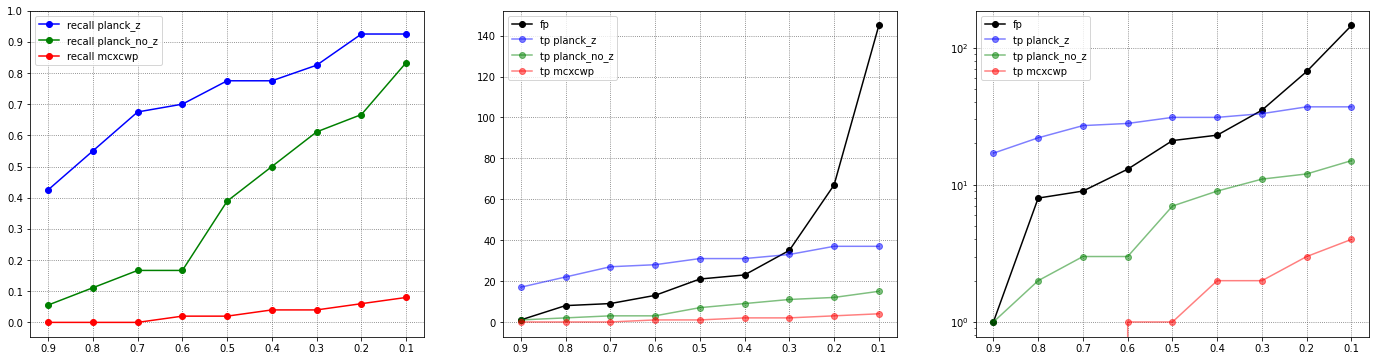

In [42]:
recall_fp_pix(6, files_dict) #test

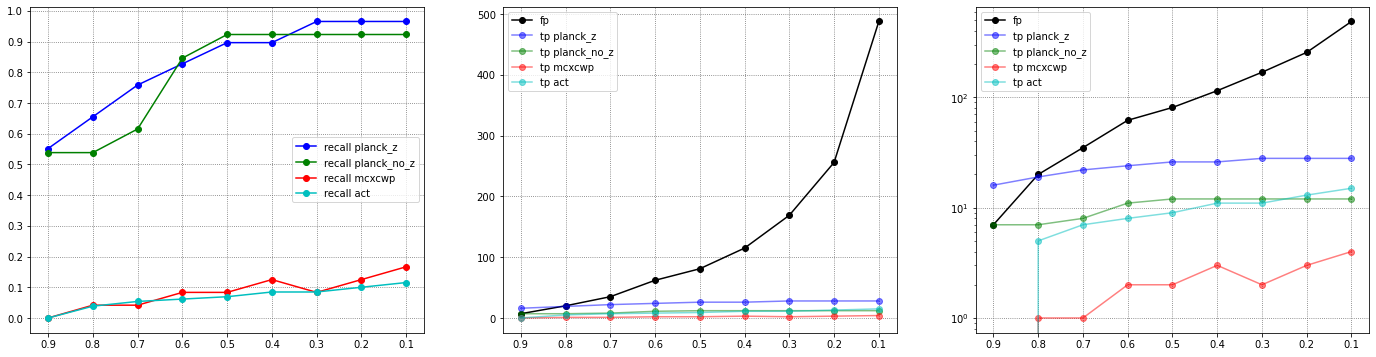

In [45]:
recall_fp_pix(val_pix[0], files_dict)

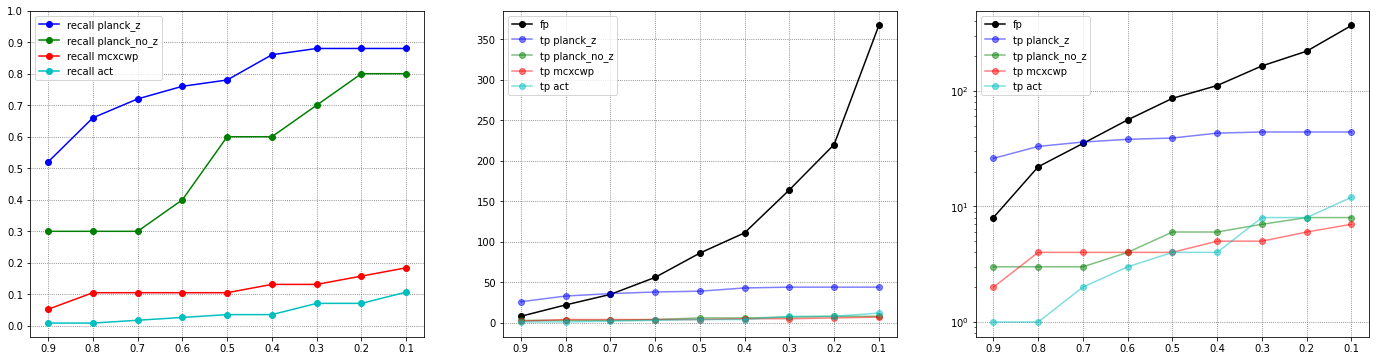

In [46]:
recall_fp_pix(val_pix[1], files_dict)

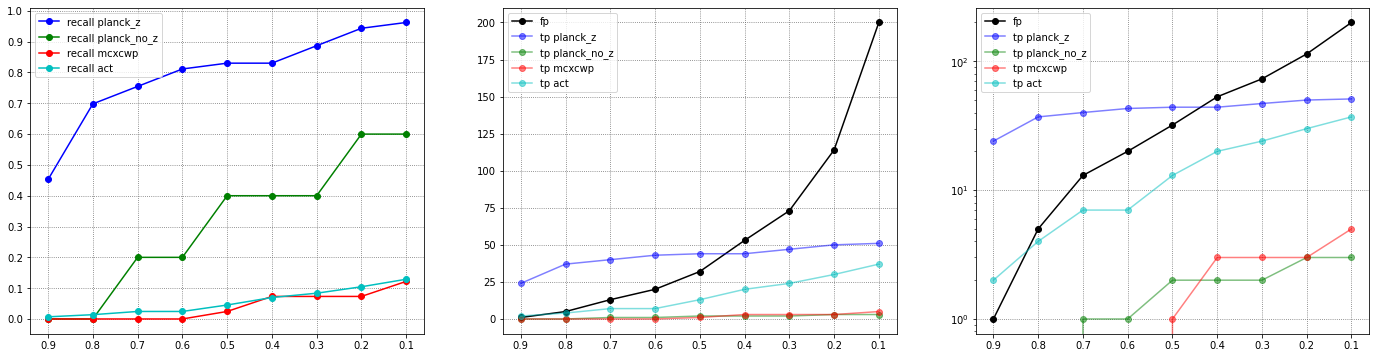

In [47]:
recall_fp_pix(val_pix[2], files_dict)

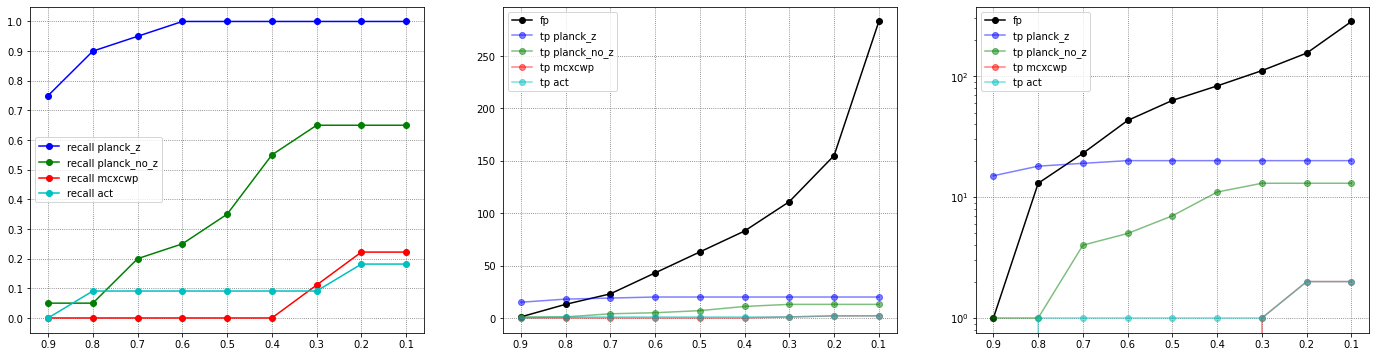

In [48]:
recall_fp_pix(0, files_dict) #train

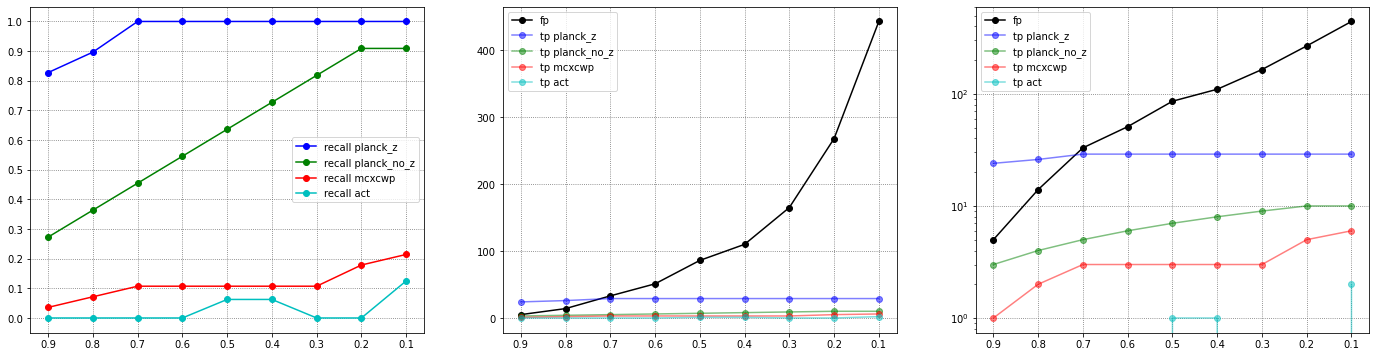

In [49]:
recall_fp_pix(14, files_dict)

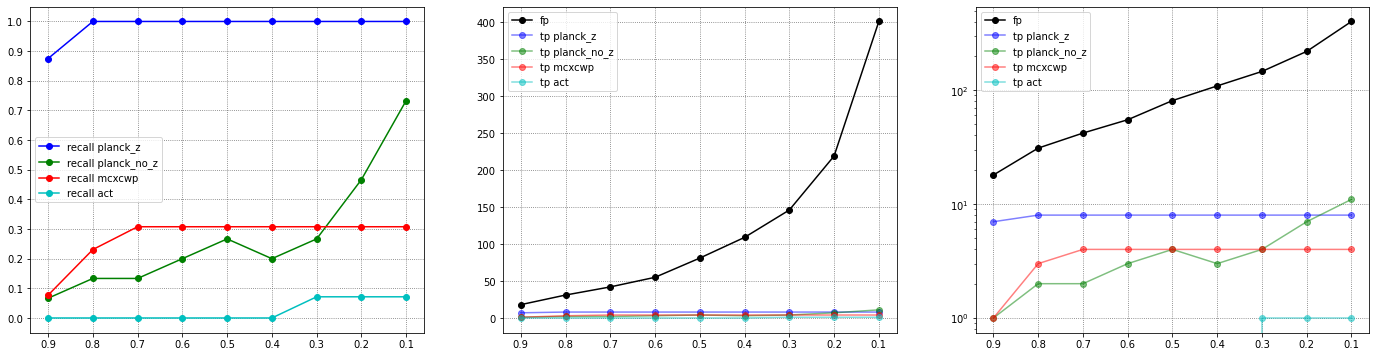

In [50]:
recall_fp_pix(24, files_dict)

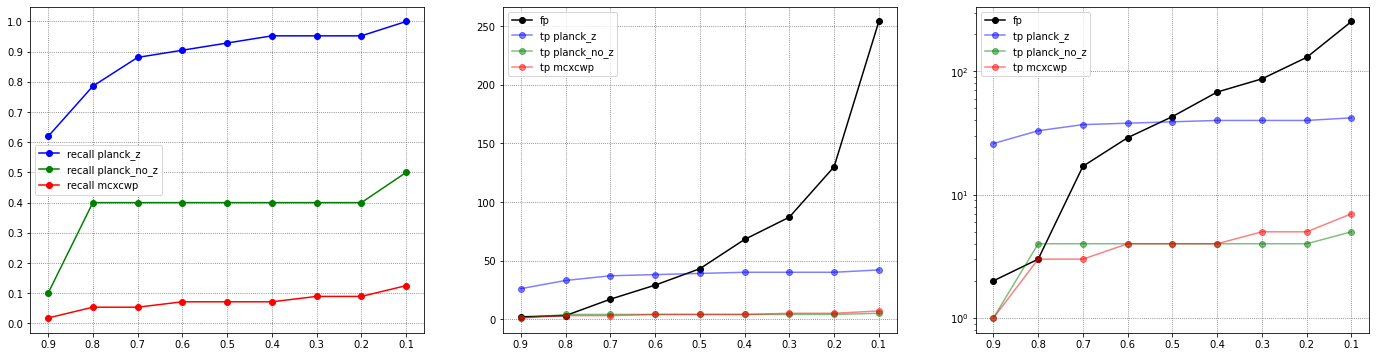

In [51]:
recall_fp_pix(7, files_dict)

In [52]:
df = pd.read_csv('/home/rt2122/Data/scans_extended/connected_ep14_thr0.4.csv')

In [57]:
nside = 2**6

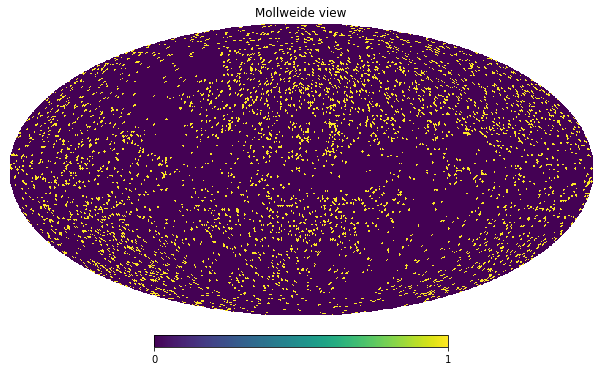

In [58]:
fp = df[df['status'] == 'fp']
fp.index = np.arange(len(fp))
a = np.zeros(hp.nside2npix(nside))
a[radec2pix(fp['RA'], fp['DEC'], nside)] = 1
hp.mollview(a, nest=True)

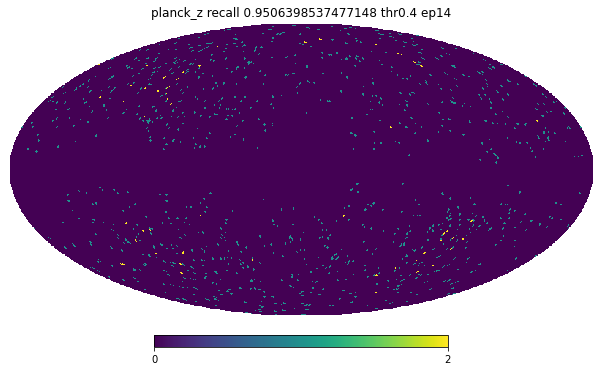

In [60]:
planck_z = df[df['catalog'] == 'planck_z']
a = np.zeros(hp.nside2npix(nside))
a[radec2pix(planck_z[planck_z['status'] == 'tp']['RA'], 
            planck_z[planck_z['status'] == 'tp']['DEC'], nside)] = 1
a[radec2pix(planck_z[planck_z['status'] == 'fn']['RA'], 
            planck_z[planck_z['status'] == 'fn']['DEC'], nside)] = 2
recall = np.count_nonzero(planck_z['status'] == 'tp') / len(planck_z)
hp.mollview(a, nest=True, 
            title='planck_z recall {recall} thr0.4 ep14'.format(recall=recall))

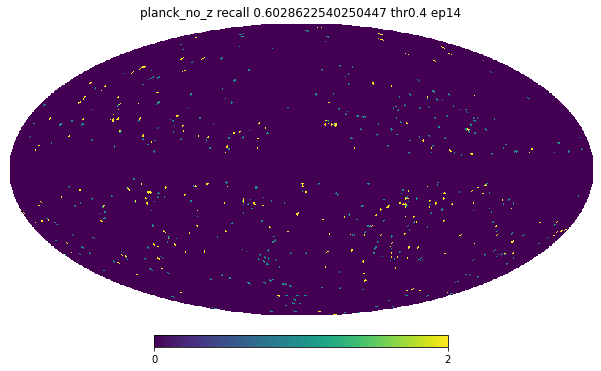

In [61]:
planck_no_z = df[df['catalog'] == 'planck_no_z']
a = np.zeros(hp.nside2npix(nside))
a[radec2pix(planck_no_z[planck_no_z['status'] == 'tp']['RA'], 
            planck_no_z[planck_no_z['status'] == 'tp']['DEC'], nside)] = 1
a[radec2pix(planck_no_z[planck_no_z['status'] == 'fn']['RA'], 
            planck_no_z[planck_no_z['status'] == 'fn']['DEC'], nside)] = 2
recall = np.count_nonzero(planck_no_z['status'] == 'tp') / len(planck_no_z)
hp.mollview(a, nest=True, 
            title='planck_no_z recall {recall} thr0.4 ep14'.format(recall=recall))

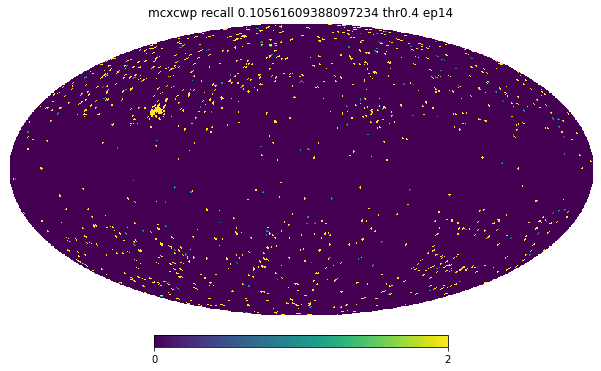

In [62]:
mcxcwp = df[df['catalog'] == 'mcxcwp']
a = np.zeros(hp.nside2npix(nside))
a[radec2pix(mcxcwp[mcxcwp['status'] == 'tp']['RA'], 
            mcxcwp[mcxcwp['status'] == 'tp']['DEC'], nside)] = 1
a[radec2pix(mcxcwp[mcxcwp['status'] == 'fn']['RA'], 
            mcxcwp[mcxcwp['status'] == 'fn']['DEC'], nside)] = 2
recall = np.count_nonzero(mcxcwp['status'] == 'tp') / len(mcxcwp)
hp.mollview(a, nest=True, 
            title='mcxcwp recall {recall} thr0.4 ep14'.format(recall=recall))

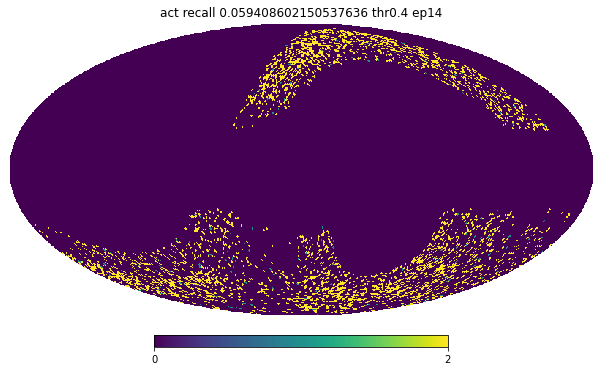

In [63]:
act = df[df['catalog'] == 'act']
a = np.zeros(hp.nside2npix(nside))
a[radec2pix(act[act['status'] == 'tp']['RA'], 
            act[act['status'] == 'tp']['DEC'], nside)] = 1
a[radec2pix(act[act['status'] == 'fn']['RA'], 
            act[act['status'] == 'fn']['DEC'], nside)] = 2
recall = np.count_nonzero(act['status'] == 'tp') / len(act)
hp.mollview(a, nest=True, 
            title='act recall {recall} thr0.4 ep14'.format(recall=recall))